## DF

In [36]:
import pandas as pd
from pathlib import Path

BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
PLOTS_PATH = BASE_PATH / "notebooks" / "plots"

df = pd.read_csv(DATA_PATH / "raw" / "train.csv")

print(f"df.shape: {df.shape}")
print(f"df.dtypes:  \n{df.dtypes}")
df.head()


df.shape: (891, 12)
df.dtypes:  
PassengerId      int64
Survived         int64
Pclass           int64
Name               str
Sex                str
Age            float64
SibSp            int64
Parch            int64
Ticket             str
Fare           float64
Cabin              str
Embarked           str
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Find NaN and duplicated**

In [37]:
missing_values = df.isna().sum().sort_values(ascending=False)

print(f"Missing values:\n{missing_values}", end="\n\n")
print(f"Duplicated values:\n{df.duplicated().sum()}")

Missing values:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

Duplicated values:
0


**Drop unnecessary columns**

In [38]:
cols_to_drop = ["Ticket", "Cabin"]

df = df.copy().drop(columns=cols_to_drop)
print(f"Duplicated values:\n{df.duplicated().sum()}")
df.head()

Duplicated values:
0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


**outliers**

In [39]:
num_cols = ["Age", "Fare"]
for col in num_cols:
    print(f"\n{col}")
    print(df.groupby("Sex")[col].agg(["min", "max", "mean", "std", "count"]))


Age
         min   max       mean        std  count
Sex                                            
female  0.75  63.0  27.915709  14.110146    261
male    0.42  80.0  30.726645  14.678201    453

Fare
         min       max       mean        std  count
Sex                                                
female  6.75  512.3292  44.479818  57.997698    314
male    0.00  512.3292  25.523893  43.138263    577


**Survival rate `["Sex", "Pclass", "Embarked"]`**

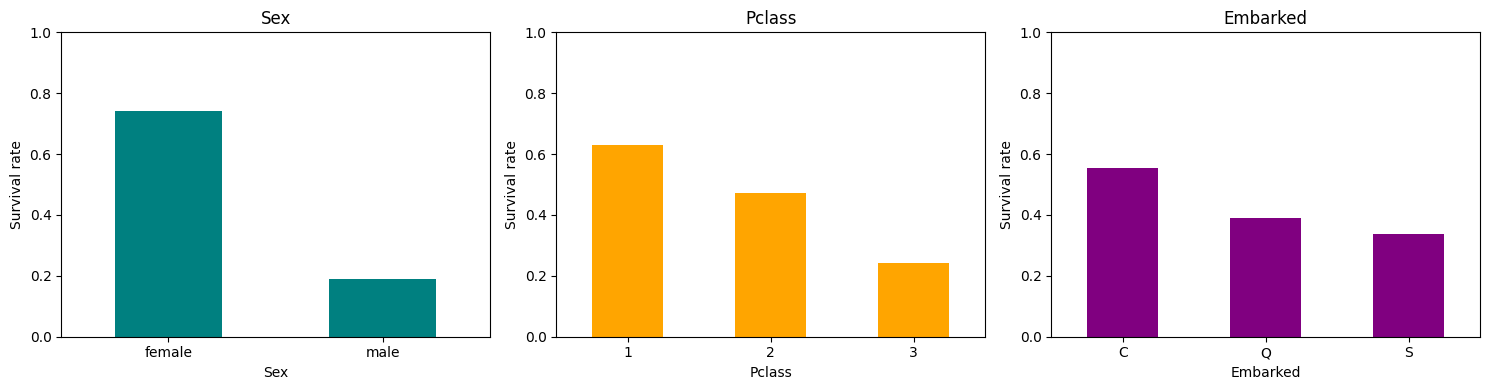

In [40]:
import matplotlib.pyplot as plt


def plot_survival_rates(df, columns, orders=None, colors=None):
    n = len(columns)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))

    if n == 1:
        axes = [axes]

    for i, (ax, col) in enumerate(zip(axes, columns)):
        rates = df.groupby(col)["Survived"].mean()

        if orders and col in orders:
            rates = rates.reindex(orders[col])

        color = colors[i] if colors else None
        rates.plot(kind="bar", ax=ax, color=color)

        ax.set_title(col)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Survival rate")
        ax.tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.show()


plot_survival_rates(
    df,
    ["Sex", "Pclass", "Embarked"],
    orders={"Pclass": [1, 2, 3], "Embarked": ["C", "Q", "S"]},
    colors=["teal", "orange", "purple"],
)

In [41]:
import pandas as pd

def build_categorical_summary(df, cols):
    tables = []

    for col in cols:
        group = df.groupby(col)["Survived"].agg(["count", "mean"])
        group = group.rename(columns={"count": "Count", "mean": "Rate"})

        group["SurvivalRate"] = ((group["Count"] / len(df)) * 100).round().astype(int).map(lambda x: f"{x}%")   
        group["Feature"] = col

        tables.append(group.reset_index().rename(columns={col: "Value"}))

    summary = pd.concat(tables, ignore_index=True)
    summary = summary[["Feature", "Value", "Count", "SurvivalRate"]]

    return summary

summary = build_categorical_summary(df, ["Sex", "Pclass", "Embarked"])
summary

,Feature,Value,Count,SurvivalRate
0,Sex,female,314,35%
1,Sex,male,577,65%
2,Pclass,1,216,24%
3,Pclass,2,184,21%
4,Pclass,3,491,55%
5,Embarked,C,168,19%
6,Embarked,Q,77,9%
7,Embarked,S,644,72%


**Fill NaN values**

`Embarked`

<small>Fill with most common value grouped by `Pclass`</small>

In [42]:
df["Embarked"] = df["Embarked"].fillna(
    df.groupby("Pclass")["Embarked"].transform(lambda x: x.mode()[0])
)
print(df.isna().sum().sort_values(ascending=False))
print(f"Duplicated: {df.duplicated().sum()}")

Age            177
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64
Duplicated: 0


`Age`

<small>Fill with most common value grouped by `[Pclass, Sex, Embarked]`</small>

In [43]:
df["Age"] = df["Age"].fillna(df.groupby(["Pclass", "Sex", "Embarked"])["Age"].transform("median"))
print(df.isna().sum().sort_values(ascending=False))
print(f"Duplicated: {df.duplicated().sum()}")

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Duplicated: 0


In [44]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


**Feature engineering**

`AgeGroup`

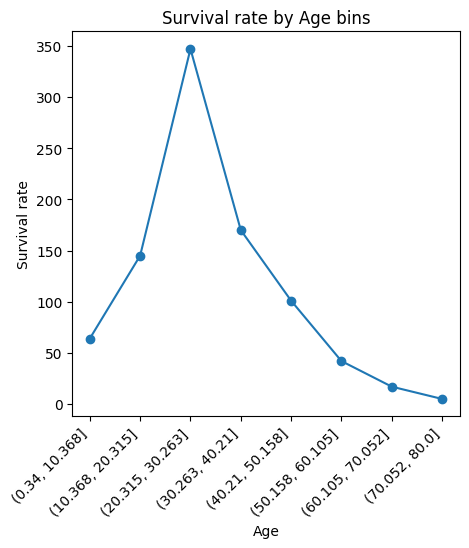

In [45]:
age_surv = df.groupby(pd.cut(df["Age"], bins=8))['Age'].count()
plt.figure(figsize=(5, 5))
age_surv.plot(marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Survival rate")
plt.title("Survival rate by Age bins")
plt.show()

In [46]:
bins = [0, 13, 18, 30, 50, 120]
labels = ["child", "teenager", "young_adult", "adult", "senior"]

def count_rate_df(df, col):
    df = df.groupby(col)["Survived"].agg(Count="count", Survival="mean").reset_index()
    df["Survival"] = (df["Survival"] * 100).round().astype(int).map(lambda x: f"{x}%")
    return df
    
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False)
count_rate_df(df, "AgeGroup")

,AgeGroup,Count,Survival
0,child,69,58%
1,teenager,51,49%
2,young_adult,403,32%
3,adult,294,42%
4,senior,74,36%


`FamilySize`

In [47]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
count_rate_df(df, "FamilySize")

,FamilySize,Count,Survival
0,1,537,30%
1,2,161,55%
2,3,102,58%
3,4,29,72%
4,5,15,20%
5,6,22,14%
6,7,12,33%
7,8,6,0%
8,11,7,0%


`IsAlone`

In [48]:
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
count_rate_df(df, "IsAlone")

,IsAlone,Count,Survival
0,0,354,51%
1,1,537,30%


`FamilyGroup`

In [49]:
df["FamilyGroup"] = pd.cut(df["FamilySize"], bins=[0, 1, 4, 20], labels=["solo", "mid", "high"])
count_rate_df(df, "FamilyGroup")
for v in ["solo", "mid", "high"]:
    print(df[df["FamilyGroup"] == v]["FamilySize"].unique())

[1]
[2 3 4]
[ 5  7  6  8 11]


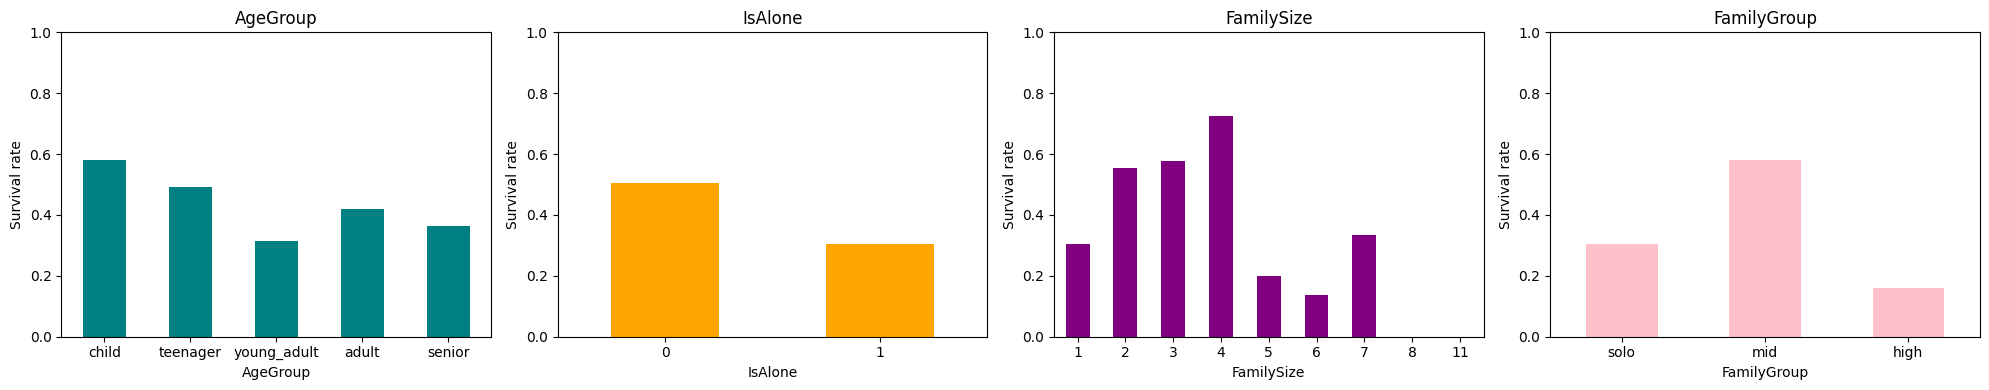

In [50]:
plot_survival_rates(
    df,
    ["AgeGroup", "IsAlone", "FamilySize", "FamilyGroup"],
    orders={
        "AgeGroup": ["child", "teenager", "young_adult", "adult", "senior"],
        "IsAlone": df["IsAlone"].unique().sort(),
        "FamilySize": df["FamilySize"].unique().sort(),
        "FamilyGroup": ["solo", "mid", "high"],
    },
    colors=["teal", "orange", "purple", "pink"],
)

**Survival rate grouped bar**

In [51]:
def plot_survival_rate_grouped_bar(
    df,
    x_col,
    hue_col,
    target_col="Survived",
    agg="mean",
    figsize=(9, 4),
    kind="bar",
    ylim=(0, 1),
    legend_title=None,
    legend_bbox=(1.05, 1),
    title=None,
    ylabel="Survival rate",
):
    # Aggregate -> pivot for plotting
    pivot = df.groupby([x_col, hue_col])[target_col].agg(agg).unstack()

    ax = pivot.plot(kind=kind, figsize=figsize)

    ax.set_ylabel(ylabel)
    ax.set_ylim(*ylim)

    if title is None:
        title = f"{target_col} ({agg}) by {x_col} and {hue_col}"
    ax.set_title(title)

    if legend_title is None:
        legend_title = hue_col
    ax.legend(title=legend_title, bbox_to_anchor=legend_bbox)

    plt.tight_layout()
    plt.show()

    return pivot

`FamilyGroup` and `AgeGroup`

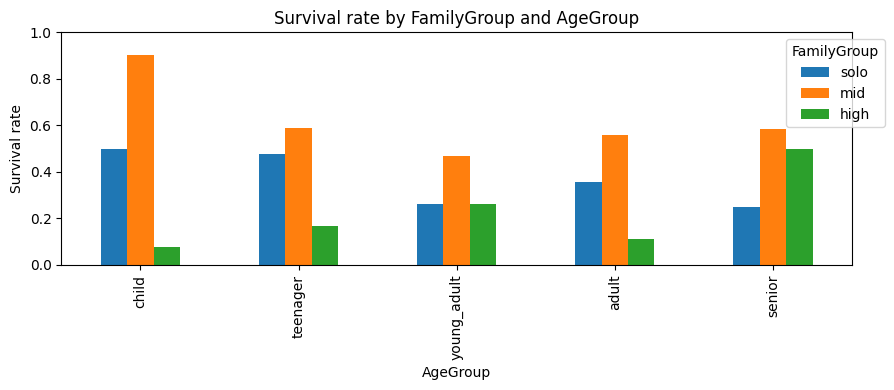

In [52]:
surv_2 = plot_survival_rate_grouped_bar(
    df,
    x_col="AgeGroup",
    hue_col="FamilyGroup",
    title="Survival rate by FamilyGroup and AgeGroup",
)

`FamilyGroup` and `AgeGroup`

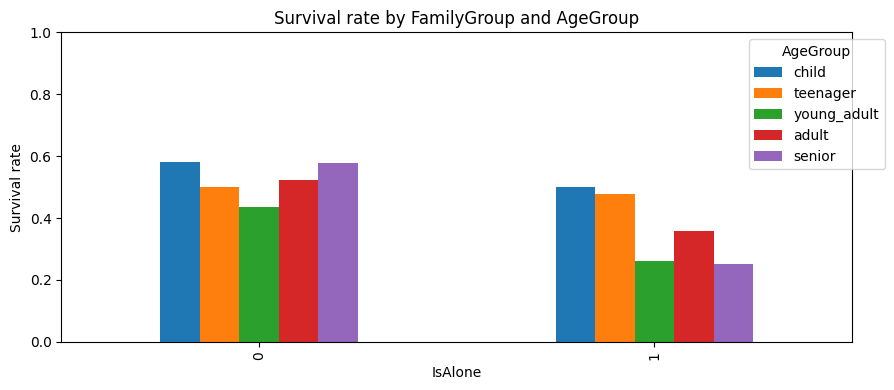

In [53]:
surv_2 = plot_survival_rate_grouped_bar(
    df,
    x_col="IsAlone",
    hue_col="AgeGroup",
    title="Survival rate by FamilyGroup and AgeGroup",
)

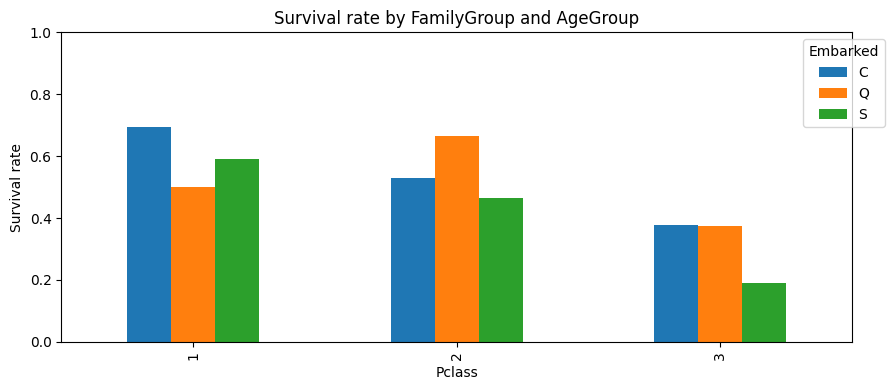

In [54]:
surv_2 = plot_survival_rate_grouped_bar(
    df,
    x_col="Pclass",
    hue_col="Embarked",
    title="Survival rate by FamilyGroup and AgeGroup",
)

In [55]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,FamilySize,IsAlone,FamilyGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,young_adult,2,0,mid
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,adult,2,0,mid
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,young_adult,1,1,solo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,adult,2,0,mid
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,adult,1,1,solo


`Fare`

In [56]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [57]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Compress the ticket price so extreme values dont dominate the model
df["Fare_log"] = np.log1p(df["Fare"])

# Scale the logged values
scaler = StandardScaler()
df["Fare_log_scaled"] = scaler.fit_transform(df[["Fare_log"]])

df[["Fare", "Fare_log", "Fare_log_scaled"]].head()

,Fare,Fare_log,Fare_log_scaled
0,7.2500,2.110213,-0.879741
1,71.2833,4.280593,1.361220
2,7.9250,2.188856,-0.798540
3,53.1000,3.990834,1.062038
4,8.0500,2.202765,-0.784179


In [58]:
df["Fare_log_scaled"].describe()

count    8.910000e+02
mean    -1.938841e-16
std      1.000562e+00
min     -3.058578e+00
25%     -8.002318e-01
50%     -2.316613e-01
75%      5.198636e-01
max      3.385294e+00
Name: Fare_log_scaled, dtype: float64

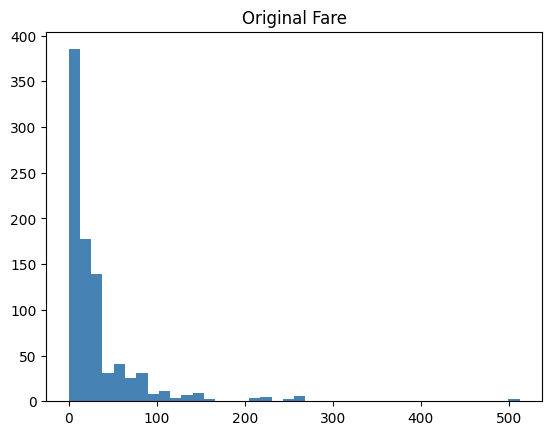

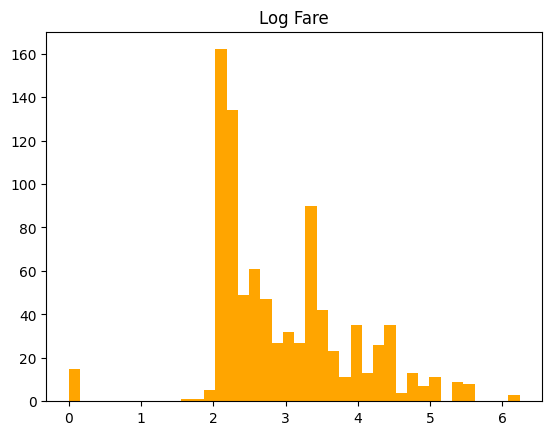

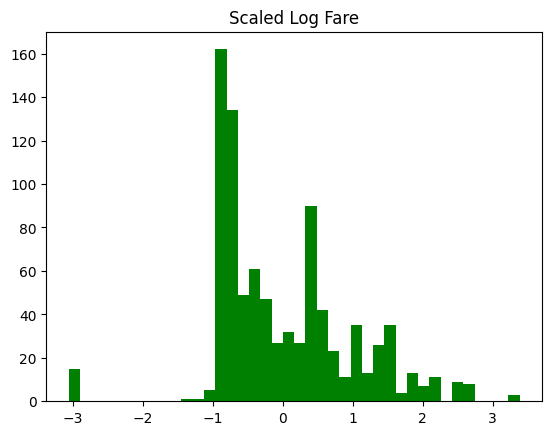

In [59]:
plt.figure()
plt.hist(df["Fare"], bins=40, color="steelblue")
plt.title("Original Fare")
plt.show()

plt.figure()
plt.hist(df["Fare_log"], bins=40, color="orange")
plt.title("Log Fare")
plt.show()

plt.figure()
plt.hist(df["Fare_log_scaled"], bins=40, color="green")
plt.title("Scaled Log Fare")
plt.show()

## new_df

**drop columns**

In [74]:
cols_to_drop = ["Name", "FamilySize", "IsAlone", "Age", "SibSp", "Parch", "Fare", "Fare_log"]
new_df = df.copy().drop(columns=cols_to_drop)
new_df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,AgeGroup,FamilyGroup,Fare_log_scaled
0,1,0,3,male,S,young_adult,mid,-0.879741
1,2,1,1,female,C,adult,mid,1.361220
2,3,1,3,female,S,young_adult,solo,-0.798540
3,4,1,1,female,S,adult,mid,1.062038
4,5,0,3,male,S,adult,solo,-0.784179


**`Sex`: Binary encoding**

In [75]:
print(f"Sex before: {df['Sex'].unique().tolist()}")
new_df["Sex"] = new_df["Sex"].map({"male": 0, "female": 1})
print(f"Sex after:  {new_df['Sex'].unique().tolist()}")

Sex before: ['male', 'female']
Sex after:  [0, 1]


**`Embarked`: OneHotEncoding**

In [76]:
embarked_map = {"S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"}

new_df["Embarked"] = new_df["Embarked"].map(embarked_map)
new_df = pd.get_dummies(new_df, columns=["Embarked"], prefix="", prefix_sep="", dtype=int)

new_df.head()

,PassengerId,Survived,Pclass,Sex,AgeGroup,FamilyGroup,Fare_log_scaled,Cherbourg,Queenstown,Southampton
0,1,0,3,0,young_adult,mid,-0.879741,0,0,1
1,2,1,1,1,adult,mid,1.361220,1,0,0
2,3,1,3,1,young_adult,solo,-0.798540,0,0,1
3,4,1,1,1,adult,mid,1.062038,0,0,1
4,5,0,3,0,adult,solo,-0.784179,0,0,1


**`AgeGroup`: OrdinalEncoding**

In [77]:
print(f"AgeGroup before: {df['AgeGroup'].unique().tolist()}")
age_map = {"child": 0, "teenager": 1, "young_adult": 2, "adult": 3, "senior": 4}
new_df["AgeGroup"] = new_df["AgeGroup"].map(age_map)
print(f"AgeGroup after:  {new_df['AgeGroup'].unique().tolist()}")

AgeGroup before: ['young_adult', 'adult', 'senior', 'child', 'teenager']
AgeGroup after:  [2, 3, 4, 0, 1]


**`FamilyGroup`: OrdinalEncoding**

In [78]:
print(f"FamilyGroup before: {df['FamilyGroup'].unique().tolist()}")
family_map = {"solo": 0, "mid": 1, "high": 2}
new_df["FamilyGroup"] = new_df["FamilyGroup"].map(family_map)
print(f"FamilyGroup after:  {new_df['FamilyGroup'].unique().tolist()}")

FamilyGroup before: ['mid', 'solo', 'high']
FamilyGroup after:  [1, 0, 2]
